In [1]:
# For google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

# Make the desired folder as Current Working Directory
os.chdir('/content/drive/MyDrive/lab7')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.feature_selection import SelectKBest,SelectPercentile, f_regression
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

In [4]:
# Calculate Regression metrices RMSE, RRMSE and R2
def reg_model_metrics(actual, pred):
    MSE = mean_squared_error(actual, pred)
    RMSE = np.sqrt(MSE)
    actual_mean = np.mean(actual)
    RRMSE = 100 * RMSE / actual_mean
    R2 = r2_score(actual, pred)
    return RMSE, RRMSE, R2

# Display prediction resutls using 1:1 scatter plot
def scatter_plot(actual, pred, title):
    RMSE, RRMSE, R2 = reg_model_metrics(actual, pred)
    fig,ax = plt.subplots()
    ax.scatter(actual, pred, edgecolors=(0,0,0))
    ax.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--', lw=2)
    text = r"R2 = %.2f" % (R2);text += "\n"; text += r"RMSE = %.2f" % (RMSE); text += "\n"
    text += r"RRMSE = %.2f" % (RRMSE) +'%'    
    plt.annotate(text, xy=(0.05, 0.85), xycoords='axes fraction',color='black', fontsize=10,
                 bbox=dict(facecolor='none',edgecolor='red'))
    ax.set_xlabel('Measured Yield (kg/ha)')
    ax.set_ylabel('Predicted Yield (kg/ha) ')
    ax.set_title(title)
    plt.show()

In [5]:
# Read the data
df = pd.read_excel('data.xlsx', header=1) 

# Get different features
y = np.asarray(df.iloc[1:,1])
x_sp = df.iloc[1:,2:23] # spectral features
x_st = df.iloc[1:,23:25] # structural features
x_th = df.iloc[1:,25] # thermal features
x_te = df.iloc[1:,26:]  # texture features
x_all = df.iloc[1:,2:] # all features

# Data preprocessing and training and testing sets spliting
x = x_sp # select the input features used as independent variables
test_size = 0.3
random_state=1

# Training and testing sets spliting
(X_train, X_test, y_train, y_test) = train_test_split(x, y, test_size=test_size, random_state=random_state)

In [6]:
# Define the model
model1 = RandomForestRegressor(random_state=1)
model2 = SVR()

In [7]:
# Build the pipelines
pipe_1 = Pipeline(steps=[('scaler', MinMaxScaler()),
                         ('model', model1)])

pipe_2 = Pipeline(steps=[('scaler', MinMaxScaler()),
                         ('pca', PCA()),
                         ('model', model2)]) 

In [8]:
# Define relevant parameters

number_of_trees = np.linspace(1, 500, num=51).tolist()
number_of_trees = [int(i) for i in number_of_trees]

max_features = ['auto', 'sqrt', 'log2']

feature_numbers = np.arange(1, X_train.shape[1]+1, 1).tolist()

pca_kernal_functions = ['linear', 'poly', 'rbf',' sigmoid']

pca_gamma = np.linspace(0.01, 0.1, 5)

In [9]:
pipe_1_param = {'model__n_estimators': number_of_trees, 'model__max_features': max_features}

pipe_2_param = {'pca__n_components': [1, 2, 3, 4, 5],
              'model__kernel': ['linear', 'rbf'],
              'model__C': [0.01, 0.1, 1, 10, 100, 1000],
              'model__gamma': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]}

In [10]:
pipe = pipe_2
pipe_params = pipe_2_param

In [11]:
%%time
# Cross validation for parameters tunning
# Extract best parameters using gridsearch_CV
grid_model = GridSearchCV(pipe, pipe_params, verbose=3, n_jobs=-1) 

# Fit the model to training set data by using thh best model parameters
grid_result = grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits
CPU times: user 3.33 s, sys: 139 ms, total: 3.47 s
Wall time: 35.7 s


In [12]:
# Get the best model
best_model = grid_result.best_estimator_

Model Training R^2: 0.55
Mode Training RMSE: 605.91
Model Training RRMSE: 20.19%
Model Testing R^2: 0.48
Mode Testing RMSE: 652.96
Model Testing RRMSE: 21.71%


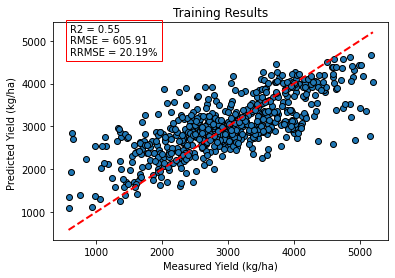

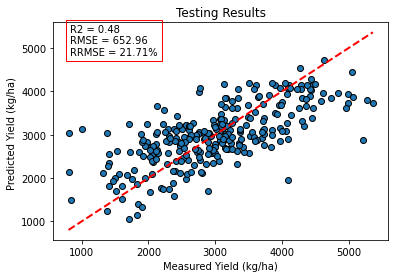

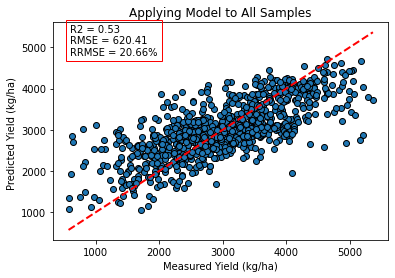

In [13]:
# Training Resutls
y_pred_train = best_model.predict(X_train)
RMSE_train, RRMSE_train, R2_train = reg_model_metrics(y_train,y_pred_train)
print('Model Training R^2: %.2f' % R2_train)
print('Mode Training RMSE: %.2f' % RMSE_train)
print('Model Training RRMSE: %.2f' % RRMSE_train +'%')

# Testing Resutls
y_pred_test = best_model.predict(X_test)
RMSE_test, RRMSE_test, R2_test = reg_model_metrics(y_test,y_pred_test)
print('Model Testing R^2: %.2f' % R2_test)
print('Mode Testing RMSE: %.2f' % RMSE_test)
print('Model Testing RRMSE: %.2f' % RRMSE_test+'%')

# Visulize the training result
title = 'Training Results'
scatter_plot(y_train,y_pred_train,title)

# Visulize the testing result
title = 'Testing Results'
scatter_plot(y_test,y_pred_test,title)

# Applying the model to all samples and visulize the result
title = 'Applying Model to All Samples'
y_pred_all = best_model.predict(x)
scatter_plot(y,y_pred_all,title)

In [14]:
# Permutation importance calclation and
def plot_permutation_importance_scores(input_model, input_x, input_y, title="Permutation Importances"):
    # Calculate the Variable Importance
    perm_imp = permutation_importance(best_model, input_x, input_y, n_repeats=10, random_state=1, n_jobs=-1)
    # Sort inices
    sorted_idx = perm_imp.importances_mean.argsort()
    
    # Plot a figure
    fig, ax = plt.subplots(dpi=90)
    ax.boxplot(perm_imp.importances[sorted_idx].T,
               vert=False,
               labels=x.columns[sorted_idx])
    ax.set_title(title)
    fig.tight_layout()
    plt.show()

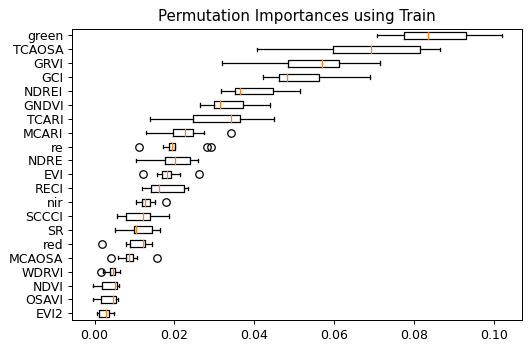

In [15]:
plot_permutation_importance_scores(best_model, X_train, y_train,
                                   title="Permutation Importances using Train")

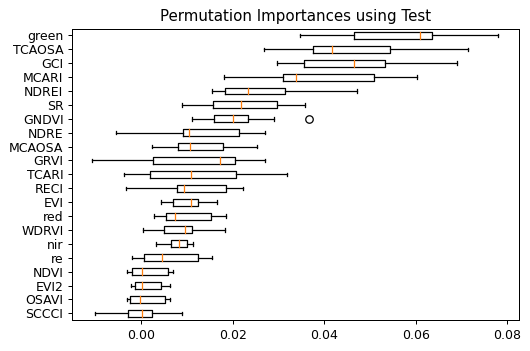

In [16]:
plot_permutation_importance_scores(best_model, X_test, y_test,
                                   title="Permutation Importances using Test")

In [17]:
pipe = pipe_1
pipe_params = pipe_1_param

In [18]:
%%time
# Cross validation for parameters tunning
# Extract best parameters using gridsearch_CV
grid_model = GridSearchCV(pipe, pipe_params, verbose=3, n_jobs=-1) 

# Fit the model to training set data by using thh best model parameters
grid_result = grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 153 candidates, totalling 765 fits
CPU times: user 5.93 s, sys: 389 ms, total: 6.32 s
Wall time: 6min 41s


In [19]:
# Get the best model
best_model = grid_result.best_estimator_

Model Training R^2: 0.93
Mode Training RMSE: 231.64
Model Training RRMSE: 7.72%
Model Testing R^2: 0.47
Mode Testing RMSE: 658.57
Model Testing RRMSE: 21.90%


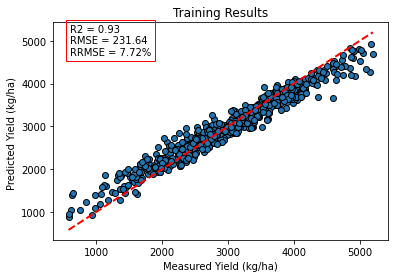

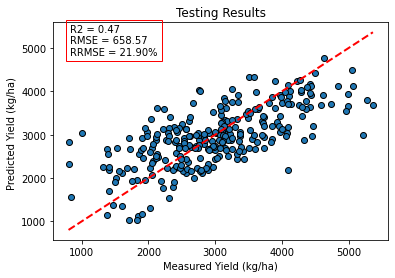

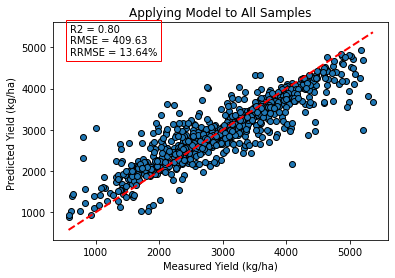

In [20]:
# Training Resutls
y_pred_train = best_model.predict(X_train)
RMSE_train, RRMSE_train, R2_train = reg_model_metrics(y_train,y_pred_train)
print('Model Training R^2: %.2f' % R2_train)
print('Mode Training RMSE: %.2f' % RMSE_train)
print('Model Training RRMSE: %.2f' % RRMSE_train +'%')

# Testing Resutls
y_pred_test = best_model.predict(X_test)
RMSE_test, RRMSE_test, R2_test = reg_model_metrics(y_test,y_pred_test)
print('Model Testing R^2: %.2f' % R2_test)
print('Mode Testing RMSE: %.2f' % RMSE_test)
print('Model Testing RRMSE: %.2f' % RRMSE_test+'%')

# Visulize the training result
title = 'Training Results'
scatter_plot(y_train,y_pred_train,title)

# Visulize the testing result
title = 'Testing Results'
scatter_plot(y_test,y_pred_test,title)

# Applying the model to all samples and visulize the result
title = 'Applying Model to All Samples'
y_pred_all = best_model.predict(x)
scatter_plot(y,y_pred_all,title)

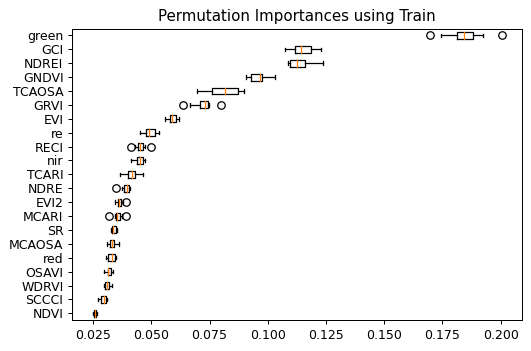

In [21]:
plot_permutation_importance_scores(best_model, X_train, y_train,
                                   title="Permutation Importances using Train")

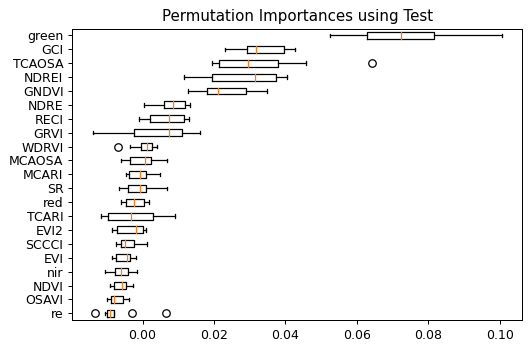

In [22]:
plot_permutation_importance_scores(best_model, X_test, y_test,
                                   title="Permutation Importances using Test")

The SVR pipeline with the given hyperparameters and correlation coefficient method performed better, getting a higher percentage right.